## Twin Analysis

The HCP databases uses a twin sample, allowing for the comparison of monozygotic (MZ) vs dizygotic (DZ) twins. 

This allows us to compare the heritability of oscillations.

In [1]:
%matplotlib inline

import random
import itertools

import numpy as  np
from scipy.stats import ttest_ind, bartlett
import matplotlib.pyplot as plt

from om.core.db import OMDB
from om.core.osc import Osc
from om.core.io import load_meg_pairs
from om.core.utils import check_file_status
from om.meg.twin import *

In [2]:
# Pull out twin data from demographics file
mz_twins, dz_twins, all_twins, not_twins = get_twin_data()

# Match twin pairs
mz_id_pairs, mz_singles = match_twins(mz_twins)
dz_id_pairs, dz_singles = match_twins(dz_twins)

# Check how many pairs where extracted
print('There are', str(len(mz_id_pairs)), 'MZ twin pairs.')
print('There are', str(len(dz_id_pairs)), 'DZ twin pairs.')

There are 18 MZ twin pairs.
There are 19 DZ twin pairs.


In [3]:
# Get database object and set up database to use
db = OMDB()
dat_source = 'HCP'

# Check which twin subjects are available
av_dat, no_dat = check_file_status(all_twins, db, dat_source='HCP', verbose=False)

# Drop outlier subject
av_dat = list(set(av_dat) - set([662551]))

In [4]:
# Given the missing data, check which twin pairs are complete
mz_complete_pairs = check_complete_pairs(mz_id_pairs, av_dat)
dz_complete_pairs = check_complete_pairs(dz_id_pairs, av_dat)

# Print out number of available pairs by twin type
print('There are', str(len(mz_complete_pairs)), 'complete MZ twin pairs.')
print('There are', str(len(dz_complete_pairs)), 'complete DZ twin pairs.')

There are 11 complete MZ twin pairs.
There are 17 complete DZ twin pairs.


In [5]:
# Check which pairs are missing (at least one) subject
print('MZ Twins Incomplete Pairs:')
print(list(set(mz_id_pairs) - set(mz_complete_pairs)))
print('DZ Twins Incomplete Pairs:')
print(list(set(dz_id_pairs) - set(dz_complete_pairs)))

MZ Twins Incomplete Pairs:
[(189349, 500222), (151526, 352132), (149741, 433839), (187547, 200109), (104012, 153732), (102816, 680957), (191033, 872764)]
DZ Twins Incomplete Pairs:
[(182840, 205119), (108323, 140117)]


In [6]:
# Get a list of all possible non-twin pairs, to compare to
all_pairs = list(itertools.combinations(av_dat, 2))
non_twin_pairs = rm_twin_pairs(all_pairs, mz_id_pairs + dz_id_pairs)

# Of all possible combinations, get a random sample of non-twin pairs, matching number of twin pairs
n_non_twin = len(mz_complete_pairs)
#n_non_twin = len(dz_complete_pairs)
#n_non_twin = 30
rand_inds = random.sample(range(len(non_twin_pairs)), n_non_twin)
non_twin_pairs = [non_twin_pairs[i] for i in rand_inds]

In [7]:
print('# MZ Pairs Used:', len(mz_complete_pairs))
print('# DZ Pairs Used:', len(dz_complete_pairs))
print('# NT Pairs Used:', len(non_twin_pairs))

# MZ Pairs Used: 11
# DZ Pairs Used: 17
# NT Pairs Used: 11


## Load Data

In [8]:
# Get database object and oscillatory band definition
db = OMDB()

In [9]:
# Set up oscillation band object 
osc = Osc()
osc.add_band('Theta', [3, 7])
osc.add_band('Alpha', [7, 14])
osc.add_band('Beta', [15, 30])

In [10]:
# Load subjects into pairs
mz_twin_dat = load_meg_pairs(mz_complete_pairs, osc_bands_vert=True, all_oscs=True, osc=osc, db=db)
dz_twin_dat = load_meg_pairs(dz_complete_pairs, osc_bands_vert=True, all_oscs=True, osc=osc, db=db)
non_twin_dat = load_meg_pairs(non_twin_pairs, osc_bands_vert=True, all_oscs=True, osc=osc, db=db)

In [11]:
# Control: check that the group don't significantly differ in age
print('MZ vs DZ\t', ttest_ind(get_pair_ages(mz_twin_dat), get_pair_ages(dz_twin_dat)))
print('MZ vs NT\t', ttest_ind(get_pair_ages(mz_twin_dat), get_pair_ages(non_twin_dat)))
print('DZ vs NT\t', ttest_ind(get_pair_ages(dz_twin_dat), get_pair_ages(non_twin_dat)))

MZ vs DZ	 Ttest_indResult(statistic=-1.6096496209887252, pvalue=0.11330548762157502)
MZ vs NT	 Ttest_indResult(statistic=-1.6595476373565603, pvalue=0.10445537606530361)
DZ vs NT	 Ttest_indResult(statistic=-0.2706038047977594, pvalue=0.787727401820347)


## Peak Frequencies

Compares the peak frequencies within oscillatory bands between twins and non-twins.

In [12]:
# Settings
peak_type = 'all'
avg = 'median'

# Compare peak frequencies
mz_peak_avg, mz_peak_dat = comp_peak_freq(mz_twin_dat, peak_type=peak_type, avg=avg)
dz_peak_avg, dz_peak_dat = comp_peak_freq(dz_twin_dat, peak_type=peak_type, avg=avg)
non_twin_peak_avg, non_twin_peak_dat = comp_peak_freq(non_twin_dat, peak_type=peak_type, avg=avg)

In [13]:
# Print out Results
print('MZ Twin Oscillatory Band Peak Frequency Results: ')
print_twin_results_vec(mz_peak_avg, osc.labels)
print('DZ Twin Oscillatory Band Peak Frequency Results: ')
print_twin_results_vec(dz_peak_avg, osc.labels)
print('Non-Twin Oscillatory Band Peak Frequency Results: ')
print_twin_results_vec(non_twin_peak_avg, osc.labels)

MZ Twin Oscillatory Band Peak Frequency Results: 
	 Theta 	 :  0.2169
	 Alpha 	 :  0.2975
	 Beta 	 :  0.6099
DZ Twin Oscillatory Band Peak Frequency Results: 
	 Theta 	 :  0.5576
	 Alpha 	 :  0.8389
	 Beta 	 :  1.0958
Non-Twin Oscillatory Band Peak Frequency Results: 
	 Theta 	 :  0.4015
	 Alpha 	 :  1.4576
	 Beta 	 :  1.8093


In [14]:
# Statistically compare differences
band_ind = 2
print(ttest_ind(mz_peak_dat[:, band_ind], dz_peak_dat[:, band_ind], equal_var=False))
print(ttest_ind(mz_peak_dat[:, band_ind], non_twin_peak_dat[:, band_ind], equal_var=False))
print(ttest_ind(dz_peak_dat[:, band_ind], non_twin_peak_dat[:, band_ind], equal_var=False))

Ttest_indResult(statistic=-2.045144310799035, pvalue=0.05352647006459145)
Ttest_indResult(statistic=-3.419839230024696, pvalue=0.005406175211125488)
Ttest_indResult(statistic=-1.7696736831615623, pvalue=0.0935846472074088)


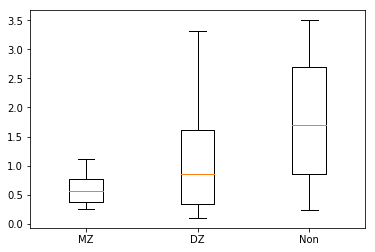

In [15]:
plt.boxplot([mz_peak_dat[:, band_ind], dz_peak_dat[:, band_ind], non_twin_peak_dat[:, band_ind]]);
plt.xticks([1, 2, 3], ['MZ', 'DZ', 'Non']);

### Oscillatory Band - Spatial Overlap

Compares the spatial topography of oscillatory bands between pairs of subject. 

Comparison is the % overlap in terms of which vertices display the oscillation.

In [16]:
# Compare spatial overlap
mz_space_avg, mz_space_dat = comp_osc_space(mz_twin_dat)
dz_space_avg, dz_space_dat = comp_osc_space(dz_twin_dat)
non_twin_space_avg, non_twin_space_dat = comp_osc_space(non_twin_dat)

In [17]:
# Print out results - each is the
print('MZ Twin Oscillatory Band Spatial Overlap Results: ')
print_twin_results_vec(mz_space_avg, osc.labels)
print('DZ Twin Oscillatory Band Spatial Overlap Results: ')
print_twin_results_vec(dz_space_avg, osc.labels)
print('Non-Twin Oscillatory Band Spatial Overlap Results: ')
print_twin_results_vec(non_twin_space_avg, osc.labels)

MZ Twin Oscillatory Band Spatial Overlap Results: 
	 Theta 	 :  0.6008
	 Alpha 	 :  0.8949
	 Beta 	 :  0.9057
DZ Twin Oscillatory Band Spatial Overlap Results: 
	 Theta 	 :  0.6094
	 Alpha 	 :  0.9147
	 Beta 	 :  0.8687
Non-Twin Oscillatory Band Spatial Overlap Results: 
	 Theta 	 :  0.6079
	 Alpha 	 :  0.8903
	 Beta 	 :  0.8860


### Oscillation Parameters Comparison

The following compares oscillatory parameters, such as center frequency, power and bandwidth from within oscillatory bands. 

NOTE: As implemented, the these comparisons are not specific to how subjects are similar/different. 
Subjects can differ in either:
- The spatial topography across which the oscillation band is found and/or
- The oscillatory parameter within the vertices where the oscillatory band is found

^ This can/will be parcelled out in further analyses:
- A basic check is simply to look at the degree of overlap of oscillatory band topographies between subjects. 

In [18]:
# Settings. Osc-Param: {0: CF, 1: Power, 2: BW}
osc_param = 1

# Compare oscillatory parameters
mz_param_avg, mz_param_dat = comp_osc_param(mz_twin_dat, osc_param)
dz_param_avg, dz_param_dat = comp_osc_param(dz_twin_dat, osc_param)
non_twin_param_avg, non_twin_param_dat = comp_osc_param(non_twin_dat, osc_param)

In [19]:
# Print out results
print('Average correlation parameters for oscillation parameter: \n')
print('MZ Twin Oscillatory Band Center Frequency Results: ')
print_twin_results_corr(mz_param_avg, osc.labels)
print('DZ Twin Oscillatory Band Center Frequency Results: ')
print_twin_results_corr(dz_param_avg, osc.labels)
print('Non-Twin Oscillatory Band Center Frequency Results: ')
print_twin_results_corr(non_twin_param_avg, osc.labels)

Average correlation parameters for oscillation parameter: 

MZ Twin Oscillatory Band Center Frequency Results: 
	 Theta 	 :  0.1634
	 Alpha 	 :  0.6722
	 Beta 	 :  0.5789
DZ Twin Oscillatory Band Center Frequency Results: 
	 Theta 	 :  0.1095
	 Alpha 	 :  0.6630
	 Beta 	 :  0.5489
Non-Twin Oscillatory Band Center Frequency Results: 
	 Theta 	 :  0.1229
	 Alpha 	 :  0.6232
	 Beta 	 :  0.5613


In [20]:
band_ind = 2
print(ttest_ind(mz_param_dat[:, band_ind, 0], dz_param_dat[:, band_ind, 0]))
print(ttest_ind(mz_param_dat[:, band_ind, 0], non_twin_param_dat[:, band_ind, 0]))
print(ttest_ind(dz_param_dat[:, band_ind, 0], non_twin_param_dat[:, band_ind, 0]))

Ttest_indResult(statistic=0.5116747991614238, pvalue=0.6131972372317092)
Ttest_indResult(statistic=0.30225597094785506, pvalue=0.7655778117513596)
Ttest_indResult(statistic=-0.21474414194396788, pvalue=0.8316422620195759)


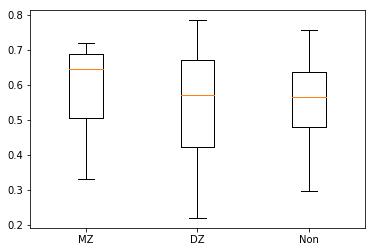

In [21]:
plt.boxplot([mz_param_dat[:, band_ind, 0],
             dz_param_dat[:, band_ind, 0],
             non_twin_param_dat[:, band_ind, 0]]);
plt.xticks([1, 2, 3], ['MZ', 'DZ', 'Non']);

## Exponent Comparison

In [22]:
# Compare exponents
mz_exp_avg, mz_exp_dat = comp_exponent(mz_twin_dat)
dz_exp_avg, dz_exp_dat = comp_exponent(dz_twin_dat)
non_twin_exp_avg, non_twin_exp_dat = comp_exponent(non_twin_dat)

In [23]:
# Print out results
print('MZ Twin Exponent Results: ')
print_twin_results_corr(mz_exp_avg, ['Exponent'])
print('DZ Twin Exponent Results: ')
print_twin_results_corr(dz_exp_avg, ['Exponent'])
print('Non-Twin Exponent Results: ')
print_twin_results_corr(non_twin_exp_avg, ['Exponent'])

MZ Twin Exponent Results: 
	 Exponent 	 :  0.5335
DZ Twin Exponent Results: 
	 Exponent 	 :  0.4156
Non-Twin Exponent Results: 
	 Exponent 	 :  0.3497


In [24]:
print(bartlett(mz_exp_dat[:, 0], dz_exp_dat[0, :]))
print(bartlett(mz_exp_dat[:, 0], non_twin_exp_dat[0, :]))
print(bartlett(dz_exp_dat[:, 0], non_twin_exp_dat[0, :]))

BartlettResult(statistic=0.3508482055338593, pvalue=0.5536333738023995)
BartlettResult(statistic=5.333772241824461, pvalue=0.020916067777944455)
BartlettResult(statistic=4.221967171887787, pvalue=0.0399038725012699)


In [25]:
# Statistically compare exponent differences
print(ttest_ind(mz_exp_dat[:, 0], dz_exp_dat[0, :], equal_var=True))
print(ttest_ind(mz_exp_dat[:, 0], non_twin_exp_dat[0, :], equal_var=True))
print(ttest_ind(dz_exp_dat[:, 0], non_twin_exp_dat[0, :], equal_var=True))

Ttest_indResult(statistic=2.767172739571163, pvalue=0.018319380883991647)
Ttest_indResult(statistic=0.36556161191524145, pvalue=0.7216246004129281)
Ttest_indResult(statistic=-0.2588607442558331, pvalue=0.7988509973378708)


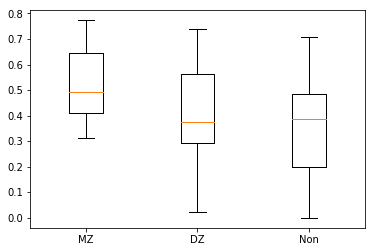

In [26]:
plt.boxplot([mz_exp_dat[:, 0], dz_exp_dat[:, 0], non_twin_exp_dat[:, 0]]);
plt.xticks([1, 2, 3], ['MZ', 'DZ', 'Non']);